In [13]:
from commonfunctions import *
import skimage as sk 
import numpy as np
import matplotlib as mp
import scipy as sp

Best angle: -30


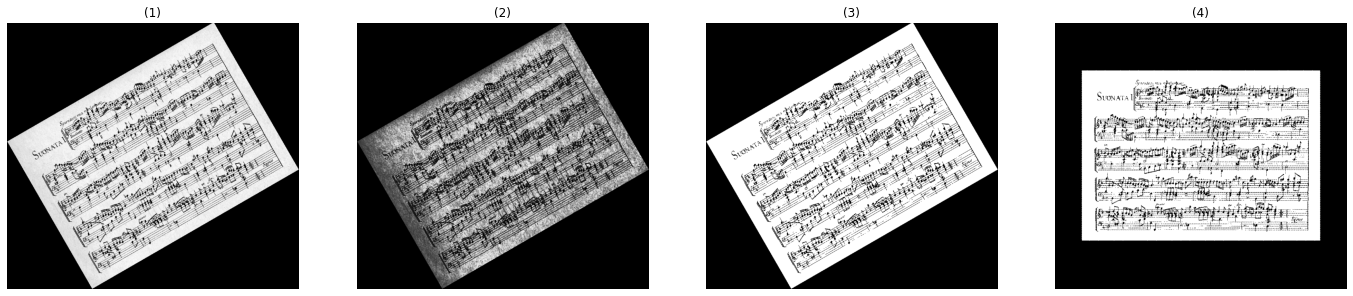

In [33]:
img = sk.io.imread('test.jpg',as_gray=True)


# noise removal 
#img = sk.filters.gaussian(img)
#img = sk.filters.median(img)

# rotate 
img = sp.ndimage.interpolation.rotate(img, 30, reshape=True, order=0)

# Equalization
img_eq = sk.exposure.equalize_hist(img)
#thresh 
t = sk.filters.threshold_otsu(img)

img_b = img >= t
# skew correction

def find_score(arr, angle):
    data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
delta = 1
limit = 50
angles = np.arange(-limit, limit+delta, delta)
scores = []
for angle in angles:
    hist, score = find_score(img_b, angle)
    scores.append(score)
best_score = max(scores)
best_angle = angles[scores.index(best_score)]
print('Best angle: '+str(best_angle))
# correct skew
data = sp.ndimage.interpolation.rotate(img_b, best_angle, reshape=False, order=0)




show_images([img,img_eq,img_b,data])